In [ ]:
#Create Dataset from kaggle and only take 5 categories
import os,time
import shutil
import numpy as np
import math
datadir="./data"
folder_list=['seg_train','seg_test']

folder_data=['data_train','data_val']

    
data=[]
all_files=['buildings','forest','glacier','mountain','sea']
    
i=0
for folder in folder_data:
    os.mkdir(datadir+"/"+folder)
    
for folderf in all_files:
    all_folder_files=[]
    for folder in folder_data:
        os.mkdir(datadir+"/"+folder+"/"+folderf)
    for flist in folder_list:
        for file in os.listdir(datadir+"/"+flist+"/"+flist+"/"+folderf):
            all_folder_files.append(datadir+"/"+flist+"/"+flist+"/"+folderf+"/"+file)
        
    trainfiles,valfiles= np.split(np.array(all_folder_files),[(math.ceil(len(all_folder_files)*0.8))])
    for name in trainfiles:
        print(name)
        shutil.copy(name,datadir+"/data_train/"+folderf)
    for name in valfiles:
        shutil.copy(name,datadir+"/data_val/"+folderf)
    while len(os.listdir(datadir+"/data_train/"+folderf))==0 or len(os.listdir(datadir+"/data_val/"+folderf))==0 :
        time.sleep(0.5)


    

# Create and Training Model

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation,BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
import numpy as np
import cv2,random
from tensorflow.keras.preprocessing.image import load_img,img_to_array
location="./data/data_val"
folder=os.listdir("./data/data_train")
x= ImageDataGenerator(
                    rescale=1./255,
                    shear_range = 0.2,
                   zoom_range = 0.2,
                    ).flow_from_directory(
"./data/data_train",  # direktori data  validation
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        class_mode='categorical',
        batch_size=32,
        seed=42,
        shuffle=True,
)
x_val=ImageDataGenerator(
                    rescale=1./255,
                    ).flow_from_directory(
"./data/data_val",  # direktori data  validation
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        class_mode='categorical',
        batch_size=32,
        seed=42,
        shuffle=True,
)

# xtest=next(x)
# x_data=xtest[0];
# y=xtest[1]
# x=[]
# y=[]
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,log={}):
    if(log['val_accuracy']>=0.86 and log['accuracy']>=0.86) :
      print("\n Menghentikan Proses Training...\n Akurasi Model 85% telah dicapai")
      self.model.stop_training=True
def dataCreate():
    data=[]
    for folderI in folder :
        y_category=[1 if f==folderI else 0 for f in folder]
        foldertes=os.listdir(location+"/"+folderI)
        for file in os.listdir(location+"/"+folderI):
            path=location+"/"+folderI+"/"+file
            img=cv2.imread(path)
            img_arr=cv2.resize(img,(150,150))
            img_arr=img_arr/255
            data.append([img_arr,y_category])
    random.shuffle(data);
    return data


#         img_arr=img_to_array(img)
#         img_arr/=255
#         x.append(img_arr)
#         y.append(np.array(y_category))
        
# # print(x[0])
# x=np.array(x)
# # x=x.reshape(-1,150,150,3)
# # print(x)
# y=np.array(y)
# print(x.shape)
# print(y.shape)
model = tf.keras.models.Sequential()
# Conv2D()
model.add(Conv2D(32,3,3,padding='same',input_shape=(150,150,3),activation='relu'))
model.add(Conv2D(32,3,3,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='same',strides=2))
model.add(Conv2D(64,3,3,padding='same',activation='relu'))
model.add(Conv2D(64,3,3,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding="same",strides=2))
model.add(Conv2D(128,3,3,padding='same',activation='relu'))
model.add(Conv2D(128,3,3,padding='same',activation='relu'))

model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Flatten())

model.add(Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(BatchNormalization())
# model.add(Dropout(0.3))
model.add(Dense(5,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
# print(x)
history=model.fit(x,
        steps_per_epoch=x.n/x.batch_size,
          validation_steps=x_val.n/x_val.batch_size,
          validation_data=x_val,
        epochs=50,
          verbose=1,
        batch_size=32,
        callbacks=[CustomCallback()],
                  shuffle=True
          
         )

Found 11320 images belonging to 5 classes.
Found 2830 images belonging to 5 classes.
Epoch 1/50
354/353 [==============================] - 160s 453ms/step - loss: 2.0594 - accuracy: 0.6094 - val_loss: 1.6451 - val_accuracy: 0.2445
Epoch 2/50
354/353 [==============================] - 135s 382ms/step - loss: 0.8590 - accuracy: 0.6890 - val_loss: 1.1654 - val_accuracy: 0.5095
Epoch 3/50
354/353 [==============================] - 141s 398ms/step - loss: 0.7637 - accuracy: 0.7227 - val_loss: 0.9641 - val_accuracy: 0.6700
Epoch 4/50
354/353 [==============================] - 144s 406ms/step - loss: 0.6817 - accuracy: 0.7584 - val_loss: 0.9462 - val_accuracy: 0.6954
Epoch 5/50
354/353 [==============================] - 147s 416ms/step - loss: 0.6261 - accuracy: 0.7812 - val_loss: 1.0284 - val_accuracy: 0.6852
Epoch 6/50
354/353 [==============================] - 140s 395ms/step - loss: 0.5968 - accuracy: 0.7912 - val_loss: 0.7912 - val_accuracy: 0.7470
Epoch 7/50
354/353 [===================

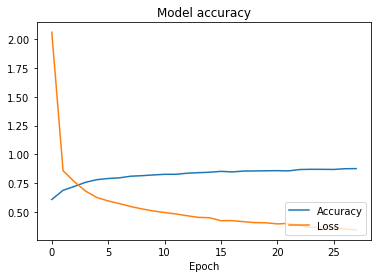

INFO:tensorflow:Assets written to: C:\Users\oscar\AppData\Local\Temp\tmpwe6vx4yt\assets


INFO:tensorflow:Assets written to: C:\Users\oscar\AppData\Local\Temp\tmpwe6vx4yt\assets


In [12]:
# Konversi model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'], loc='lower right')
plt.show()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)